# Insurance Prediction 🩺🧾

## About Dataset
- **age**: Age of primary beneficiary
- **sex**: Insurance contractor gender, female, male
- **bmi**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- **children**: Number of children covered by health insurance / Number of dependents
- **smoker**: Smoking
- **region**: The beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- **charges**: Individual medical costs billed by health insurance

## Importing Dataset, Required Libraries and Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

sns.set_palette("Paired")

data = pd.read_csv('insurance.csv')
df = data.copy()

# Exploratory Data Analysis

## Data Overview

In [2]:
def analyze_df(dataframe):
    
    print(f"Shape: {dataframe.shape}")
    print("------------------------------ Head ------------------------------")
    print(dataframe.head(10))
    print("------------------------------ Tail ------------------------------")
    print(dataframe.tail())
    print("------------------------------ Data Types ------------------------------")
    print(dataframe.dtypes)
    print("------------------------------ Unique Values -----------------------------")
    print(dataframe.nunique())
    print("------------------------------ NaN Values -----------------------------")
    print(dataframe.isnull().sum())
    print("------------------------------ Quantiles ------------------------------")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    

analyze_df(df)

Shape: (1338, 7)
------------------------------ Head ------------------------------
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
5   31  female  25.740         0     no  southeast   3756.62160
6   46  female  33.440         1     no  southeast   8240.58960
7   37  female  27.740         3     no  northwest   7281.50560
8   37    male  29.830         2     no  northeast   6406.41070
9   60  female  25.840         0     no  northwest  28923.13692
------------------------------ Tail ------------------------------
      age     sex    bmi  children smoker     region     charges
1333   50    male  30.97         3     no  northwest  10600.5483
1334   18  fema

In [3]:
df["charges"].mean()

13270.422265141257

In [4]:
df["charges"].std()

12110.011236694001

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Provides the names of categorical, numeric, and categorical-like but cardinal variables in the dataset.
    Note: Numeric-looking categorical variables are also included in categorical variables.

    Parameters
    ------
    dataframe: dataframe
            DataFrame from which variable names are to be extracted.
    cat_th: int, optional
            Class threshold value for numeric but categorical variables.
    car_th: int, optional
            Class threshold value for categorical but cardinal variables.

    Returns
    ------
        cat_cols: list
                List of categorical variable names.
        num_cols: list
                List of numeric variable names.
        cat_but_car: list
                List of categorical-like but cardinal variable names.

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
        

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables.
        num_but_cat is within cat_cols.
    """
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df, car_th=10)

Observations: 1338
Variables: 7
cat_cols: 4
num_cols: 3
cat_but_car: 0
num_but_cat: 1


## Categorical & Numerical Variable Analysis

In [6]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


for col in cat_cols:
    target_summary_with_cat(df, "charges", col)

         TARGET_MEAN
sex                 
female  12569.578844
male    13956.751178


         TARGET_MEAN
smoker              
no       8434.268298
yes     32050.231832


            TARGET_MEAN
region                 
northeast  13406.384516
northwest  12417.575374
southeast  14735.411438
southwest  12346.937377


           TARGET_MEAN
children              
0         12365.975602
1         12731.171832
2         15073.563734
3         15355.318367
4         13850.656311
5          8786.035247




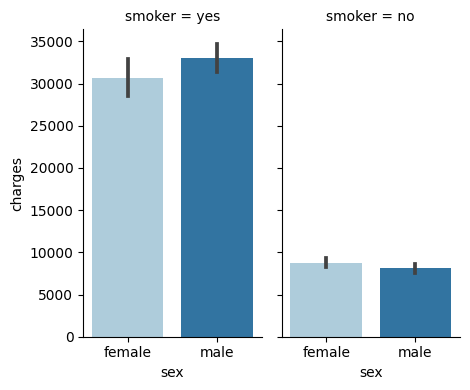

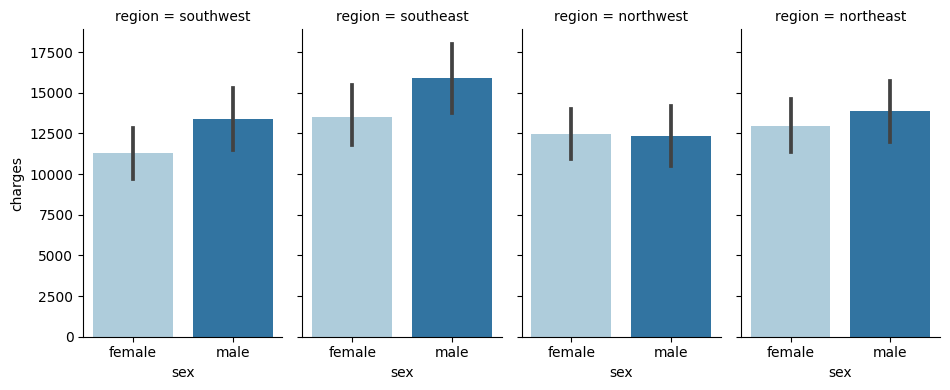

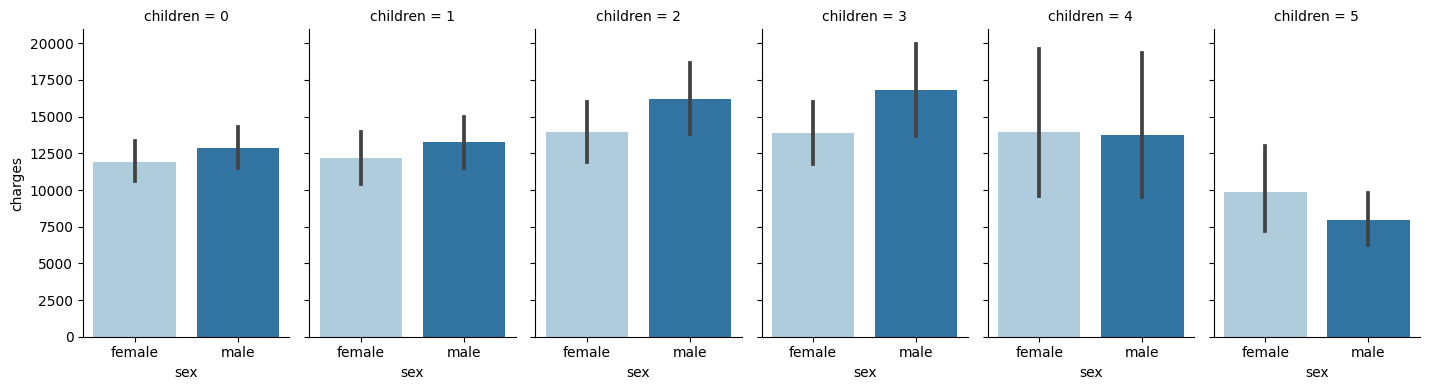

In [7]:
for cols in cat_cols:
    if cols != "sex":
        g = sns.catplot(data=df, x="sex", y="charges",
                        col=cols, kind="bar",
                        height=4, aspect=.6,)

In [8]:
def target_summary_with_num(dataframe, target, numerical_col):  
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

    
for col in num_cols:
    if col != "charges":
        target_summary_with_num(df, "charges", col)

              age
charges          
1121.87390   18.0
1131.50660   18.0
1135.94070   18.0
1136.39940   18.0
1137.01100   18.0
...           ...
55135.40209  33.0
58571.07448  31.0
60021.39897  52.0
62592.87309  45.0
63770.42801  54.0

[1337 rows x 1 columns]


                bmi
charges            
1121.87390   23.210
1131.50660   30.140
1135.94070   33.330
1136.39940   33.660
1137.01100   34.100
...             ...
55135.40209  35.530
58571.07448  38.095
60021.39897  34.485
62592.87309  30.360
63770.42801  47.410

[1337 rows x 1 columns]




count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
5%         18.000000
10%        19.000000
20%        24.000000
30%        29.000000
40%        34.000000
50%        39.000000
60%        44.000000
70%        49.000000
80%        54.000000
90%        59.000000
95%        62.000000
99%        64.000000
max        64.000000
Name: age, dtype: float64


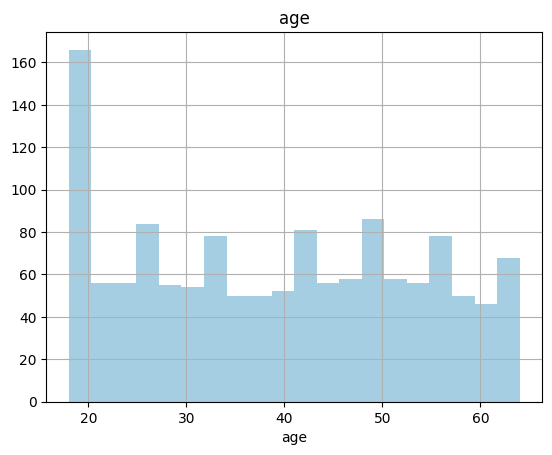

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
5%         21.256000
10%        22.990000
20%        25.326000
30%        27.360000
40%        28.797000
50%        30.400000
60%        32.032000
70%        33.660000
80%        35.860000
90%        38.619500
95%        41.106000
99%        46.407900
max        53.130000
Name: bmi, dtype: float64


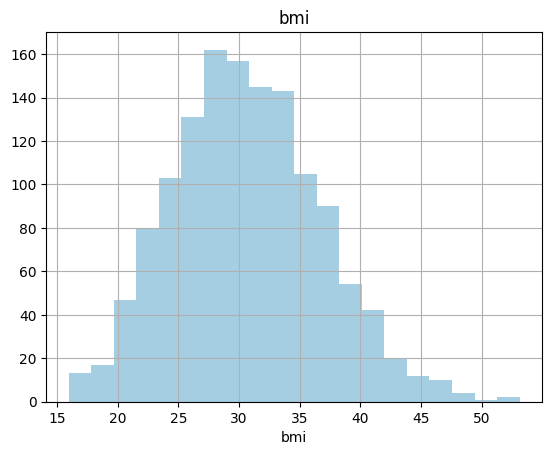

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
5%        1757.753400
10%       2346.533615
20%       3991.575720
30%       5484.846770
40%       7369.052730
50%       9382.033000
60%      11399.857160
70%      13767.875345
80%      20260.626406
90%      34831.719700
95%      41181.827787
99%      48537.480726
max      63770.428010
Name: charges, dtype: float64


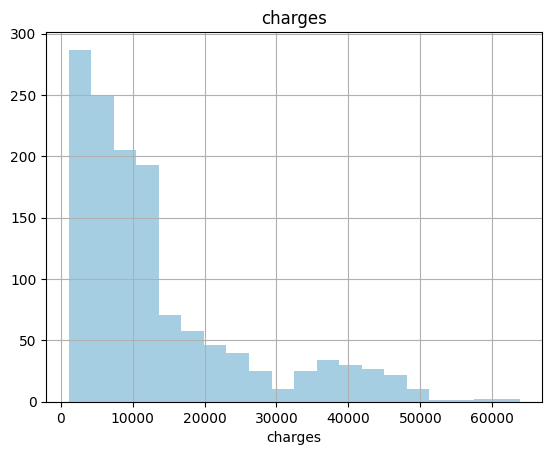

In [9]:
def num_summary(dataframe, numerical_col, plot=True):
    
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col)

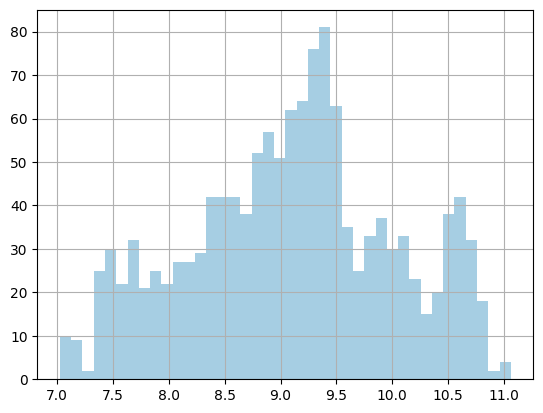

In [10]:
np.log1p(df['charges']).hist(bins=40)
plt.show()

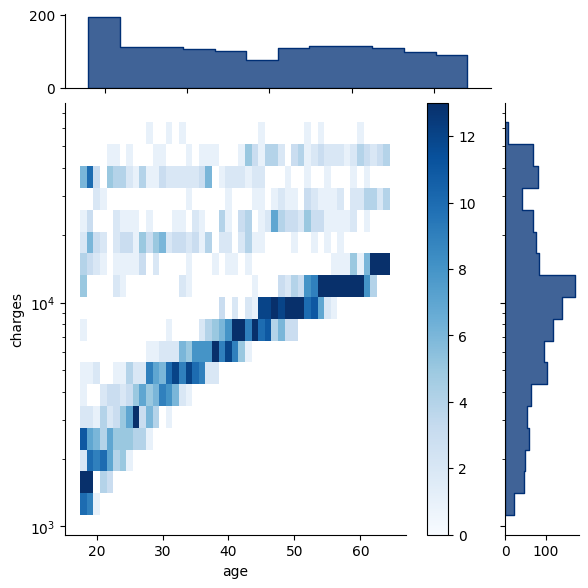

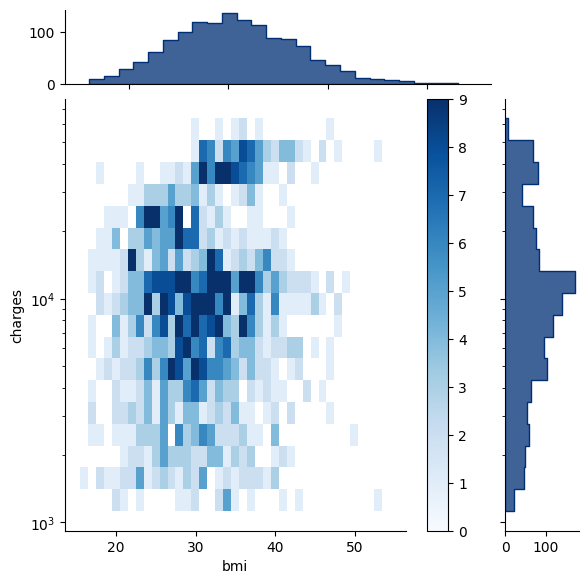

In [11]:
for col in num_cols:
    if col != "charges":
        g = sns.JointGrid(data=df, x=col, y="charges", marginal_ticks=True)
        g.ax_joint.set(yscale="log")

        g.plot_joint(sns.histplot,
                     discrete=(True, False),
                     cmap="Blues", pmax=.8, cbar=True)
        
        g.plot_marginals(sns.histplot, element="step", color="#002F75")

## Correlation Matrix

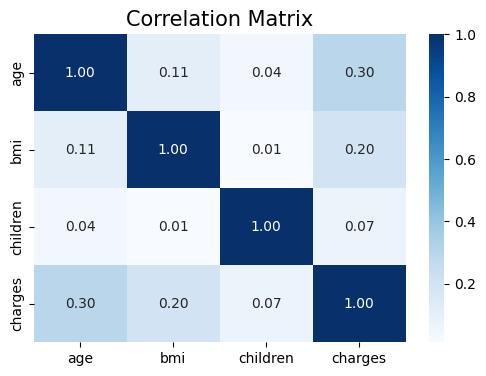

In [12]:
corr = df.corr()
f, ax = plt.subplots(figsize=[6, 4])
ax.set_title("Correlation Matrix", fontsize=15)
sns.heatmap(corr, annot=True, fmt=".2f", ax=ax, cmap="Blues")
plt.show()

# Data Pre-processing

## Outliers

In [13]:
def outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    quantile1 = dataframe[variable].quantile(q1)
    quantile3 = dataframe[variable].quantile(q3)
    interquantile_range = quantile3 - quantile1
    up_limit = quantile3 + 1.5 * interquantile_range
    low_limit = quantile1 - 1.5 * interquantile_range
    return low_limit, up_limit


for col in num_cols:
    if col != "charges":
        print(col, outlier_thresholds(df, col))

age (-48.0, 128.0)
bmi (-8.51899999999998, 70.88099999999997)


In [14]:
def check_outlier(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    
    if dataframe[(dataframe[column] > up_limit) | (dataframe[column] < low_limit)].any(axis=None):
        return True
    
    else:
        return False
    
    
for col in num_cols:
    if col != "charges":
        print(col, check_outlier(df, col))

age False
bmi False


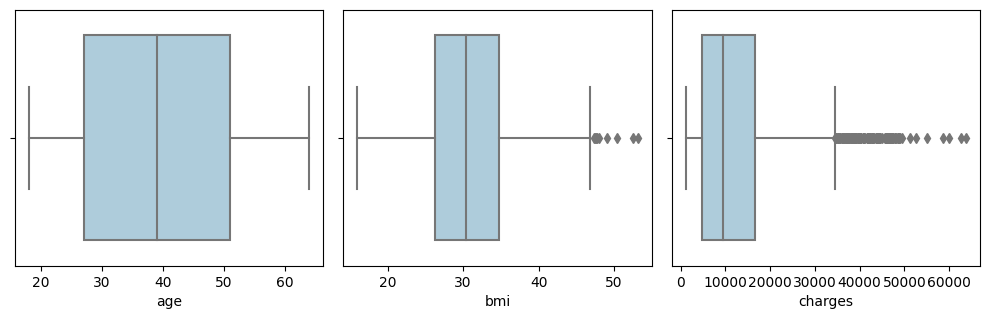

In [15]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 3, 1)
sns.boxplot(x=df["age"])
plt.subplot(2, 3, 2)
sns.boxplot(x=df["bmi"])
plt.subplot(2, 3, 3)
sns.boxplot(x=df["charges"])

plt.tight_layout()
plt.show()

## Rare Analysis

In [16]:
def rare_analyser(dataframe, target, categorical_columns):
    """
    Analyzes rare categories in categorical columns with respect to a target column.

    Parameters
    ------
        dataframe: pd.DataFrame
                   DataFrame containing the data.
        target: str
                The name of the target column.
        cat_cols: list
                  List of categorical variable names.
    Returns
    ------
        None
    """
    for col in cat_cols:
        value_counts = dataframe[col].value_counts()
        ratio = value_counts / len(dataframe)
        target_mean = dataframe.groupby(col)[target].mean()
        
        print(f"{col}:", len(value_counts))

        rare_df = pd.DataFrame({"COUNT": value_counts,
                                "RATIO": ratio,
                                "TARGET_MEAN": target_mean})

        print(rare_df, end="\n\n\n")
        
        
rare_analyser(df, "charges", cat_cols)

sex: 2
        COUNT     RATIO   TARGET_MEAN
female    662  0.494768  12569.578844
male      676  0.505232  13956.751178


smoker: 2
     COUNT     RATIO   TARGET_MEAN
no    1064  0.795217   8434.268298
yes    274  0.204783  32050.231832


region: 4
           COUNT     RATIO   TARGET_MEAN
northeast    324  0.242152  13406.384516
northwest    325  0.242900  12417.575374
southeast    364  0.272048  14735.411438
southwest    325  0.242900  12346.937377


children: 6
   COUNT     RATIO   TARGET_MEAN
0    574  0.428999  12365.975602
1    324  0.242152  12731.171832
2    240  0.179372  15073.563734
3    157  0.117339  15355.318367
4     25  0.018685  13850.656311
5     18  0.013453   8786.035247




In [17]:
# inclusion of classes in other classes according to their proportions
df["region"] = np.where(df.region.isin(["northeast", "northwest"]), "north", df["region"])
df["region"] = np.where(df.region.isin(["southeast", "southwest"]), "south", df["region"])

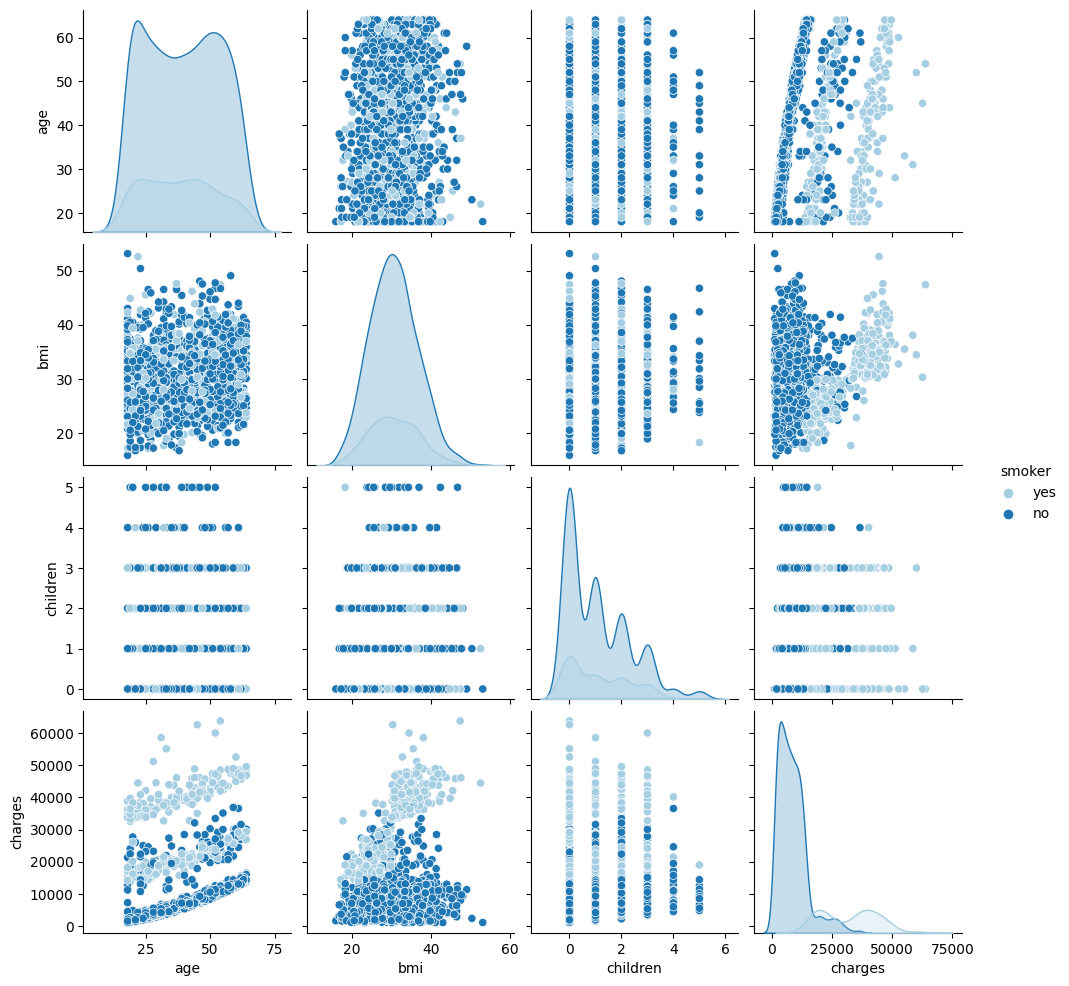

In [19]:
sns.pairplot(df, hue="smoker")

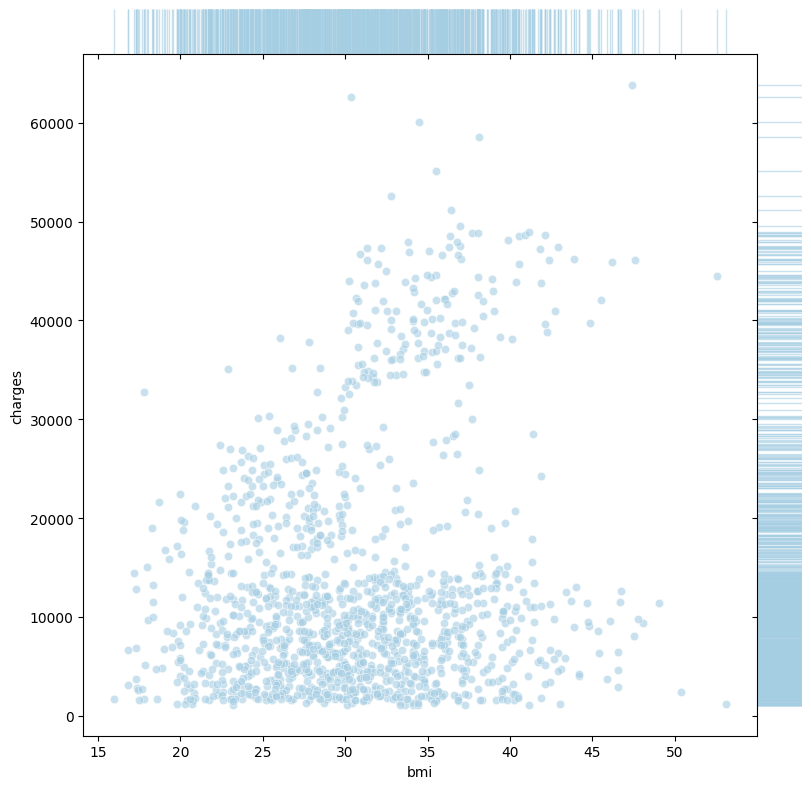

In [21]:
g = sns.JointGrid(data=df, x="bmi", y="charges", space=0, ratio=15, height=8)
g.plot_joint(sns.scatterplot, alpha=.6, legend=False)
g.plot_marginals(sns.rugplot, height=1, alpha=.6)

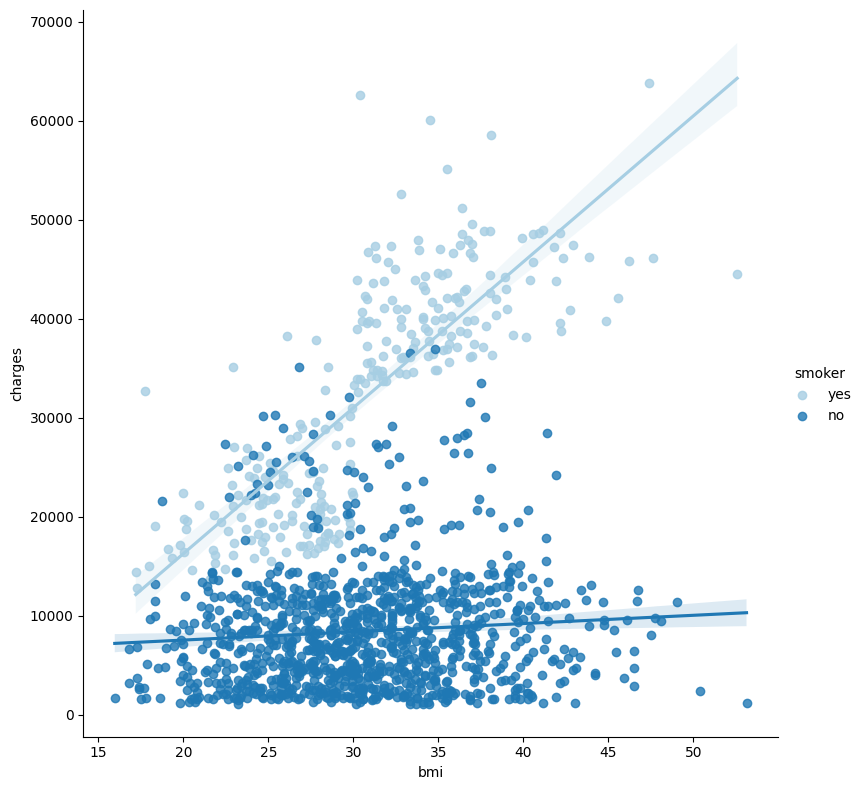

In [22]:
g = sns.lmplot(data=df,
               x="bmi", y="charges", hue="smoker",
               height=8)

In [23]:
# feature extraction
df['overall'] = df['bmi'] + df['age']
df.columns = [col.upper() for col in df.columns]

In [24]:
df.head()

,AGE,SEX,BMI,CHILDREN,SMOKER,REGION,CHARGES,OVERALL
0,19,female,27.900,0,yes,south,16884.92400,46.900
1,18,male,33.770,1,no,south,1725.55230,51.770
2,28,male,33.000,3,no,south,4449.46200,61.000
3,33,male,22.705,0,no,north,21984.47061,55.705
4,32,male,28.880,0,no,north,3866.85520,60.880


## Encoding

In [25]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1338
Variables: 8
cat_cols: 4
num_cols: 4
cat_but_car: 0
num_but_cat: 1


In [26]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and len(df[col].unique()) == 2]
binary_cols

['SEX', 'SMOKER', 'REGION']

In [27]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


for col in binary_cols:
    df = label_encoder(df, col)

In [28]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


df = one_hot_encoder(df, cat_cols, drop_first=True)

# Modelling

In [29]:
y = df["CHARGES"]
X = df.drop(["CHARGES"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=15)

In [30]:
# scaling
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [31]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor(force_col_wise=True)),
          ("CatBoost", CatBoostRegressor(verbose=False))]


for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name})")

RMSE: 6079.1838 (LR)
RMSE: 6073.6075 (Ridge)
RMSE: 6073.7492 (Lasso)
RMSE: 11440.7537 (KNN)
RMSE: 6588.2706 (CART)
RMSE: 4919.9085 (RF)
RMSE: 4592.1238 (GBM)
RMSE: 5247.4754 (XGBoost)
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 10
[LightGBM] [Info] Start training from score 13182.325247


C:\Users\SUDE\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Sistem belirtilen dosyayı bulamıyor
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\SUDE\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\SUDE\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\SUDE\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1024, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\U

[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 10
[LightGBM] [Info] Start training from score 13325.937689
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 10
[LightGBM] [Info] Start training from score 13367.020035
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 1071, number of used features: 10
[LightGBM] [Info] Start training from score 13237.871925
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 1071, number of used features: 9
[LightGBM] [Info] Start training from score 13239.016175
RMSE: 4796.9702 (LightGBM)
RMSE: 4785.8715 (CatBoost)


In [32]:
gbm_model = GradientBoostingRegressor()
rmse = np.mean(np.sqrt(-cross_val_score(gbm_model, X, y, cv=5, scoring="neg_mean_squared_error")))
rmse

4599.1787488980735

In [33]:
gbm_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [34]:
gbm_params = {"learning_rate": [0.01, 0.1],
              "min_samples_split": [2, 5, 8, 15, 20],
              "n_estimators": [100, 500, 1000],
              "subsample": [1, 0.5, 0.7]}

gbm_gscv = GridSearchCV(gbm_model,
                        gbm_params,
                        cv=5,
                        n_jobs=-1,
                        verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


In [35]:
gbm_gscv.best_params_

{'learning_rate': 0.01,
 'min_samples_split': 5,
 'n_estimators': 500,
 'subsample': 0.7}

In [36]:
final_model = gbm_model.set_params(**gbm_gscv.best_params_).fit(X, y)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))
rmse

4507.756671579487

## Feature Importance

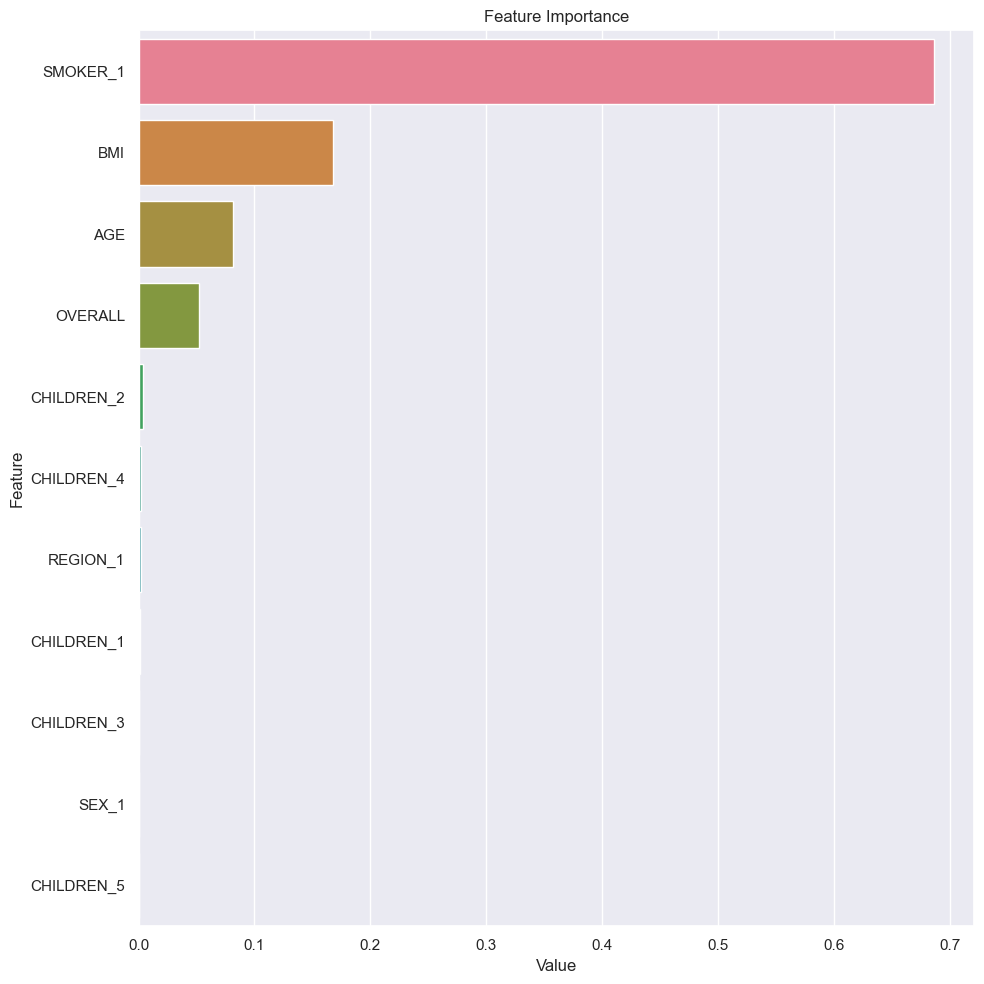

In [37]:
def plot_importance(model, features, num=len(X), save=False):
    
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num], palette="husl")
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    if save:
        plt.savefig('importances.png')
        
model = GradientBoostingRegressor()
model.fit(X, y)


plot_importance(model, X, num=20)